# Cleaning TUIK Data

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re

In [2]:
path_to_data = 'data/TUIK'
file_names = os.listdir(path_to_data)
file_names

['consumer_confidence_index.csv',
 'consumer_price_index.csv',
 'export_import.xlsx',
 'export_import1.xls',
 'export_import2.xls',
 'export_import3.xls',
 'export_import4.xls',
 'export_unit_value_index.csv',
 'gdp_expenditure.csv',
 'gdp_income.csv',
 'gdp_production.csv',
 'import_unit_value_index.csv',
 'industrial_production_index1.csv',
 'industrial_production_index2.csv',
 'unemployment1.xls',
 'unemployment2.csv']

### Export-Import data

In [ ]:
def save_data(df, save_path):
    assert save_path is not None, "Provide save_path"
    
    df.to_csv(

In [55]:
def clean_import_export(read_path, save_path=None, save_data=False, return_data=True):

    df = pd.read_excel(path)
    
    df = df.dropna(how='all')

    # Renaming columns
    df = df.rename(columns={'Yıl': 'year', 'Ay': 'month', 'İhracat Dolar': 'exports_usd',
               'İhracat TL/YTL': 'exports_tl', 'İthalat Dolar': 'imports_usd', 'İthalat TL/YTL': 'imports_tl'})

    # Filling empty year values
    df['year'] = df['year'].fillna(method='ffill').astype('int')

    # Dropping "Toplam" rows
    cond = df['month'].astype('str').str.isnumeric()
    df = df.loc[cond]
    df['month'] = df['month'].astype('int').copy()

    # Removing period from numeric columns and converting to int 
    cols = ['exports_usd', 'exports_tl', 'imports_usd', 'imports_tl']

    for col in cols:
        df[col] = df[col].str.replace('.', '', regex=False)
        df[col] = df[col].astype('int64')
    
    # Adding date column
    df['day'] = 1
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day'])
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [56]:
file_name = 'export_import.xlsx'
read_path = os.path.join(path_to_data, file_name)
save_path = 'cleaned_data/export_import.csv'
# clean_import_export(read_path, save_path, save_data=True, return_data=False)

In [61]:
# Loading cleaned data
df = pd.read_csv('cleaned_data/export_import.csv', parse_dates=['date'])

In [62]:
df.head()

,date,year,month,exports_usd,exports_tl,imports_usd,imports_tl
0,2005-01-01,2005,1,4997279724,6791013684,7219679862,9812593440
1,2005-02-01,2005,2,5651741252,7449079145,8323736797,10998599631
2,2005-03-01,2005,3,6591859218,8638660740,10196352932,13302963657
3,2005-04-01,2005,4,6128131878,8333848266,9595500303,13036202298
4,2005-05-01,2005,5,5977226217,8198283737,9811620456,13450174257


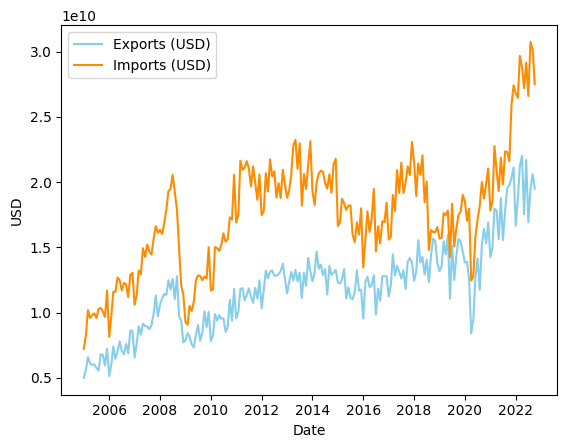

In [63]:
plt.plot('date', 'exports_usd', data=df, color='skyblue', label='Exports (USD)')
plt.plot('date', 'imports_usd', data=df, color='darkorange', label='Imports (USD)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

## GDP data
There are 5 files for GDP:
* gdp_expenditure: Gross Domestic Product  By Expenditure Approach (2009 Base)
    * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    
* gdp_income: Gross Domestic Product  By Income Approach (2009 Base)
    * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    
* gdp_production: Gross Domestic Product  By Production Approach (2009 Base). The original file (gdp_production_original) has GDp by production approach computed using three methods. I divided the original file into three files for easier processing:
    * gdp_production1:
        * Current Prices and Thousand Try and B1G. (Gross Value Added)
    * gdp_production2:
        * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    * gdp_production3:
        * Current Prices and Thousand Try and D21X31. (Taxes Less Subsidies On Products)

In [81]:
def clean_gdp_data(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_csv(path, sep='|', skiprows=3, header=None)
    
    df = df.iloc[:, 3:8]
    
    df.columns = ['year', 'q1', 'q2', 'q3', 'q4']
    
    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    # Melting dataframe
    df = df.melt(id_vars=['year'], value_vars=['q1', 'q2', 'q3', 'q4'])
    
    m = re.compile(r'.*(gdp_\w+)\.csv$')
    name = re.search(m, path).group(1)

    df = df.rename(columns={'value': name, 'variable': 'quarter'})
    df = df.dropna()
    
    df['quarter'] = df['quarter'].apply(lambda x: x[1]).astype('int')
    
    # Adding date column
    df['day'] = 1
    df['month'] = df['quarter'].replace({1: 1, 2: 4, 3:7, 4:10})
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day', 'month'])
             
    df = df.sort_values(by='date')
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df
    
    return df

In [84]:
gdp_files = [
    'gdp_expenditure.csv',
    'gdp_income.csv',
    'gdp_production1.csv',
    'gdp_production2.csv',
    'gdp_production3.csv'
]

path_to_data = 'data/TUIK'

df_list = []

for file_name in gdp_files:
    path = os.path.join(path_to_data, file_name)
    df = clean_gdp_data(path, return_data=True)
    df_list.append(df)

# Merging data
merged_df = df_list[0].copy()
for df in df_list[1:]:
    merged_df = merged_df.merge(df, on=['date', 'year', 'quarter'])

In [90]:
# Saving data
# merged_df.to_csv('cleaned_data/gdp.csv', index=False)

In [130]:
df = pd.read_csv('cleaned_data/gdp.csv', parse_dates=['date'])

In [131]:
df.head()

,date,year,quarter,gdp_expenditure,gdp_income,gdp_production1,gdp_production2,gdp_production3
0,2005-01-01,2005,1,142588340.0,142588340.0,125072561.0,142588340.0,17515778.0
1,2005-04-01,2005,2,163510888.0,163510888.0,142322731.0,163510888.0,21188157.0
2,2005-07-01,2005,3,186658293.0,186658293.0,163591890.0,186658293.0,23066403.0
3,2005-10-01,2005,4,187518326.0,187518326.0,163896094.0,187518326.0,23622232.0
4,2006-01-01,2006,1,162557040.0,162557040.0,141101974.0,162557040.0,21455066.0


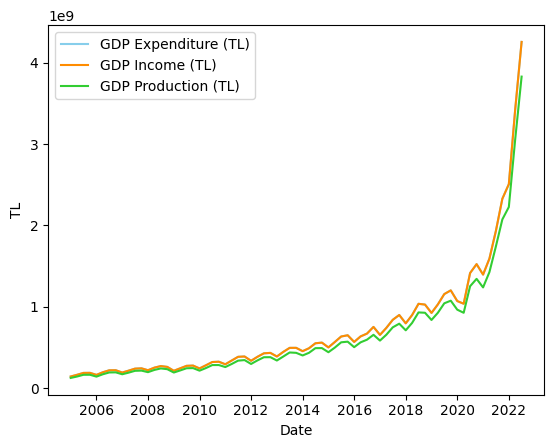

In [94]:
plt.plot('date', 'gdp_expenditure', data=df, color='skyblue', label='GDP Expenditure (TL)')
plt.plot('date', 'gdp_income', data=df, color='darkorange', label='GDP Income (TL)')
plt.plot('date', 'gdp_production1', data=df, color='limegreen', label='GDP Production (TL)')
plt.xlabel('Date')
plt.ylabel('TL')
plt.legend()
plt.show()

## Consumer Price Index (2003=100)

In [140]:
def clean_cpi_data(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_csv(read_path, sep='|', skiprows=4, header=None)

    df = df.iloc[:, 2:15]
    
    df.columns = ['year'] + list(range(1, 13))

    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    # Melting dataframe
    df = df.melt(id_vars=['year'], value_vars=df.columns[1:])

    df = df.rename(columns={'value': 'consumer_price_index', 'variable': 'month'})
    df = df.dropna()
    
    # Adding date column
    df['day'] = 1
    df['month'] = df['month'].astype('int')
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day'])
             
    df = df.sort_values(by='date')
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [122]:
path = 'data/TUIK/consumer_price_index.csv'
save_path = 'cleaned_data/consumer_price_index.csv'
# df = clean_cpi_data(path, save_data=True, save_path=save_path)

In [132]:
df = pd.read_csv('cleaned_data/consumer_price_index.csv', parse_dates=['date'])

In [133]:
df.head()

,date,year,month,consumer_price_index
0,2005-01-01,2005,1,114.49
1,2005-02-01,2005,2,114.51
2,2005-03-01,2005,3,114.81
3,2005-04-01,2005,4,115.63
4,2005-05-01,2005,5,116.69


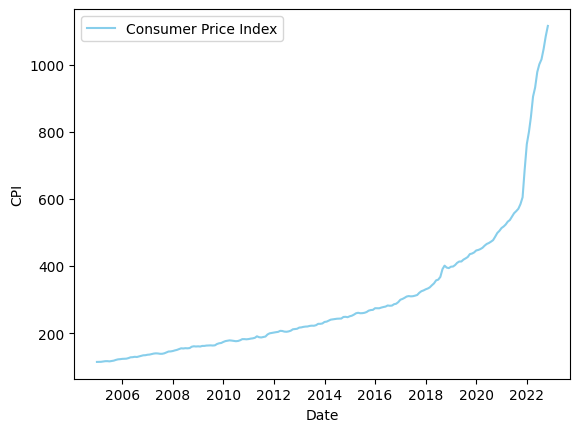

In [134]:
plt.plot('date', 'consumer_price_index', data=df, color='skyblue', label='Consumer Price Index')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

## Export and Import Unit Value Index (2010=100)
The file **export_unit_value_index.csv** contains this index in both TL and USD. Only the USD value will be kept in the cleaned file. However, the TL value can be retrieved when necessary. In addition, we can use the USD/TL rate in this file as rate for all TL --> USD conversions we make in this project.

### Notes:
* The value of the index in TL is lower than its value in USD in some years (like 2005 and 2006). However at that time 1 USD was about 1.5 TL, so if the two indexes are the same the USD index should have a lower value. Is this index computed differently in USD and TL?

In [235]:
def clean_export_import_unit_val_index_data(read_path, which, save_path=None, save_data=False, return_data=True):
    '''
    which should be "import" or "export".
    '''
    df = pd.read_csv(read_path, sep='|', skiprows=4, header=None)

    if which == 'export':
        df = df.iloc[:, 1:27]
        df = df.drop(columns=[2])
        
    elif which == 'import':
        df = df.iloc[:, 2:27]
    
    tl_columns = list(map(lambda x: f'{x}_tl', range(1, 13)))
    usd_columns = list(map(lambda x: f'{x}_usd', range(1, 13)))
    df.columns = ['year'] + tl_columns + usd_columns
    
    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    df_usd = df[['year'] + usd_columns].copy()
    df_tl = df[['year'] + tl_columns].copy()

    # Variable name
    idx = len(read_path) - read_path[::-1].find('/') - 1
    name = read_path[idx+1:-4]
    
    df_list = []
    
    for df in [df_usd, df_tl]:
        # Converting column names back to months
        df.columns = ['year'] + list(range(1, 13))
        
        # Melting dataframe
        df = df.melt(id_vars=['year'], value_vars=df.columns[1:])
        df = df.rename(columns={'value': name, 'variable': 'month'})
        df = df.dropna()
        
        # Adding date column
        df['day'] = 1
        df['month'] = df['month'].astype('int')
        df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
        df = df.drop(columns=['day'])
        
        df = df.sort_values(by='date')
        
        df_list.append(df)
    
    # Merging USD and TL dataframes
    df = df_list[0].merge(df_list[1], on=['date', 'year', 'month'], suffixes=('_usd', '_tl'))
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [241]:
read_path = 'data/TUIK/export_unit_value_index.csv'
save_path = 'cleaned_data/export_unit_value_index.csv'

# df = clean_export_import_unit_val_index_data(read_path, which='export', save_data=True, save_path=save_path)

In [248]:
# Loading data
save_path = 'cleaned_data/export_unit_value_index.csv'
df = pd.read_csv(save_path, parse_dates=['date'])

In [249]:
df.head()

,date,year,month,export_unit_value_index_usd,export_unit_value_index_tl
0,2005-01-01,2005,1,86.8,78.4
1,2005-02-01,2005,2,86.5,75.8
2,2005-03-01,2005,3,87.9,76.6
3,2005-04-01,2005,4,86.6,78.3
4,2005-05-01,2005,5,86.6,78.9


Notice how the USD index values sometimes exceeded the TL index value, indicating that the value of TL was higher than the value of USD at that time (under the assumption that the index value is computed in the same way for both USD and TL, the only difference being the currency).

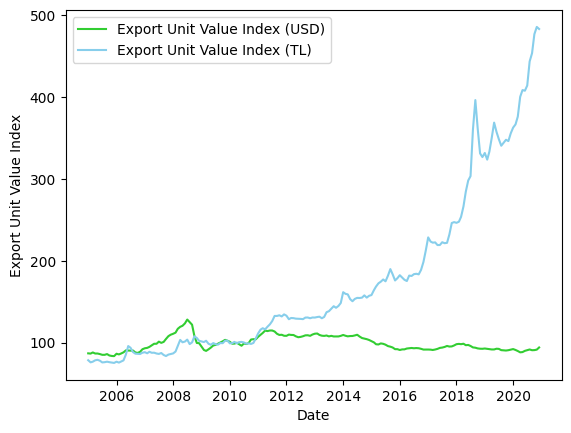

In [243]:
plt.plot('date', 'export_unit_value_index_usd', data=df, color='limegreen', label='Export Unit Value Index (USD)')
plt.plot('date', 'export_unit_value_index_tl', data=df, color='skyblue', label='Export Unit Value Index (TL)')
plt.xlabel('Date')
plt.ylabel('Export Unit Value Index')
plt.legend()
plt.show()

In [244]:
read_path = 'data/TUIK/import_unit_value_index.csv'
save_path = 'cleaned_data/import_unit_value_index.csv'

# df = clean_export_import_unit_val_index_data(read_path, which='import', save_data=True, save_path=save_path)

In [245]:
# Loading data
save_path = 'cleaned_data/import_unit_value_index.csv'
df = pd.read_csv(save_path, parse_dates=['date'])

In [246]:
df.head()

,date,year,month,import_unit_value_index_usd,import_unit_value_index_tl
0,2005-01-01,2005,1,80.7,73.0
1,2005-02-01,2005,2,80.0,70.4
2,2005-03-01,2005,3,81.1,70.4
3,2005-04-01,2005,4,85.3,77.2
4,2005-05-01,2005,5,80.2,73.2


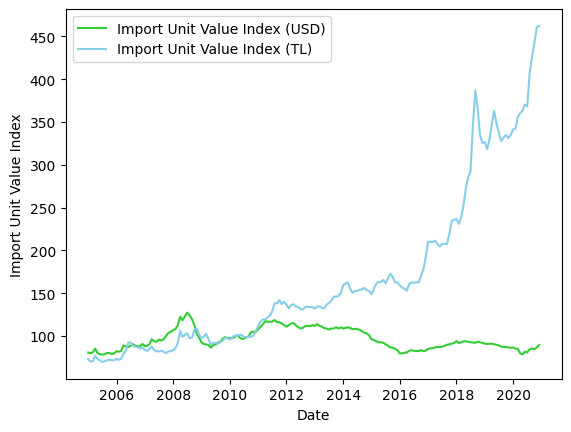

In [247]:
plt.plot('date', 'import_unit_value_index_usd', data=df, color='limegreen', label='Import Unit Value Index (USD)')
plt.plot('date', 'import_unit_value_index_tl', data=df, color='skyblue', label='Import Unit Value Index (TL)')
plt.xlabel('Date')
plt.ylabel('Import Unit Value Index')
plt.legend()
plt.show()

## Unemployment Rates
There are two files for unemployment rates:
* unemployment1
* unemployment2

I manually converted unemployment1 to .xlsx format as the original .xls format is not readable in Pandas. The original file is saved as unemployment1_original.

In [268]:
path = 'data/TUIK/unemployment1.xlsx'
df = pd.read_excel(path)

In [269]:
df.columns = ['date'] + list(df.columns[1:])

In [270]:
df.insert(1, 'year', df['date'].apply(lambda x: int(x.split(' ')[0])))
df.insert(2, 'month', df['date'].apply(lambda x: x.split(' ')[1]))